In [12]:
from scipy.integrate import odeint
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import lombscargle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import scipy.signal as signal
import itertools
import random
import seaborn as sns

In [13]:
def extract_features(x, y, v_x, v_y):
    """
    Extract features from the time series data for use in machine learning models.

    :param x: X position data array.
    :param y: Y position data array.
    :param v_x: X velocity data array.
    :param v_y: Y velocity data array.
    :return: Extracted features.
    """
    features = {
        'x_mean': np.mean(x),
        'y_mean': np.mean(y),
        'x_var': np.var(x),
        'y_var': np.var(y),
        'x_skew': skew(x),
        'y_skew': skew(y),
        'x_kurt': kurtosis(x),
        'y_kurt': kurtosis(y),
        'v_x_mean': np.mean(v_x),
        'v_y_mean': np.mean(v_y),
        'v_x_var': np.var(v_x),
        'v_y_var': np.var(v_y),
        'v_x_skew': skew(v_x),
        'v_y_skew': skew(v_y),
        'v_x_kurt': kurtosis(v_x),
        'v_y_kurt': kurtosis(v_y),
    }
    
    return features

In [15]:
def subsample_time_series(t, x, y, v_x, v_y, subsample_size=30):
    """
    Subsample the time series data to simulate incomplete observations.

    :param t: Time points array.
    :param x: X position data array.
    :param y: Y position data array.
    :param v_x: X velocity data array.
    :param v_y: Y velocity data array.
    :param subsample_size: The number of data points to subsample to.
    :return: Subsampled time series data.
    """
    # Ensure we always subsample the same way for reproducibility
    np.random.seed(0)
    
    # Choose random indices for subsampling
    subsample_indices = np.random.choice(len(t), size=subsample_size, replace=False)
    subsample_indices.sort()  # Sort the indices to maintain the time order
    
    return t[subsample_indices], x[subsample_indices], y[subsample_indices], v_x[subsample_indices], v_y[subsample_indices]

In [16]:
def remove_outliers(df, column_names):
    """
    Remove outliers from a pandas DataFrame based on the interquartile range.

    :param df: Pandas DataFrame.
    :param column_names: List of column names to check for outliers.
    :return: DataFrame with outliers removed.
    """
    clean_df = df.copy()
    
    for column in column_names:
        Q1 = clean_df[column].quantile(0.10)
        Q3 = clean_df[column].quantile(0.90)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out the outliers
        clean_df = clean_df[(clean_df[column] >= lower_bound) & (clean_df[column] <= upper_bound)]
    
    return clean_df

In [17]:
def simulate_system(func, initial_conditions, t, params):
    """
    Generalized simulation function for different potentials.

    :param func: Function representing the equations of motion.
    :param initial_conditions: Initial conditions for the simulation.
    :param t: Array of time points for the simulation.
    :param params: Parameters required for the specific potential.
    :return: Simulated time series data.
    """
    solution = odeint(func, initial_conditions, t, args=params)

    x = solution[:,0]
    y = solution[:,1]
    v_x = solution[:,2]
    v_y = solution[:,3]
    
    return x, y, v_x, v_y


In [18]:
def simulate_harmonic_oscillator(initial_conditions, t, omega, a):
    def equations_of_motion(xyv_xv_y, t, omega, a):
        x, y, v_x, v_y = xyv_xv_y
        return [v_x, v_y, a - omega**2 * x, a - omega**2 * y]
    
    return simulate_system(equations_of_motion, initial_conditions, t, (omega, a))

In [19]:
def simulate_modified_newtonian(initial_conditions, t, b, a):
    def equations_of_motion(xyv_xv_y, t, b, a):
        x, y, v_x, v_y = xyv_xv_y
        return [v_x, v_y, -x / (x**2 + y**2)**(3/2), -y / (x**2 + y**2)**(3/2)]

    return simulate_system(equations_of_motion, initial_conditions, t, (b, a))

In [20]:
def generate_sine_wave(t, A, w, psi):

    sigma = 0.2*A
    w_noise = np.random.default_rng(2).normal(0, sigma , 100)
    
    wave = A * (np.sin(w*t + psi) + w_noise)     
    
    return wave

def extract_features_from_wave(x, t):
    """
    Extract features from the wave time series data for use in machine learning models.

    :param x: Wave data array (either sine or cosine wave).
    :param t: Time points array corresponding to the wave data.
    :return: Extracted features as a dictionary.
    """
    # Example feature extraction from the wave
    v_x = np.gradient(x, t)  # Derivative of x to simulate velocity-like feature

    features = {
        'x_mean': np.mean(x),
        'y_mean': 0,  # Placeholder as sine/cosine waves don't have y-component
        'x_var': np.var(x),
        'y_var': 0,  # Placeholder
        'x_skew': skew(x),
        'y_skew': 0,  # Placeholder
        'x_kurt': kurtosis(x),
        'y_kurt': 0,  # Placeholder
        'v_x_mean': np.mean(v_x),
        'v_y_mean': 0,  # Placeholder for velocity in y-direction
        'v_x_var': np.var(v_x),
        'v_y_var': 0,  # Placeholder
        'v_x_skew': skew(v_x),
        'v_y_skew': 0,  # Placeholder
        'v_x_kurt': kurtosis(v_x),
        'v_y_kurt': 0,  # Placeholder
        # Additional features can be added here if necessary
    }
    
    return features

In [21]:
#Ondas seno

seed_value = 40
rng = np.random.default_rng(seed_value)

w = rng.uniform(0.1, 9.5, 5)
A = rng.uniform(0.1, 5, 5)
psi = rng.uniform(0.1, 10, 5)

t = rng.uniform(0, 30, 100)
t.sort()

data_features = []
data_frec = []

for i in w:
    for j in A:
        for k in psi:

            x = generate_sine_wave(t, j, i, k)

            #Calculamos la frecuencia
            frec = i
            
            # Extract features from the time series data
            features = extract_features_from_wave(x, t)

            # Store the features and peak frequency
            data_features.append(features)
            data_frec.append(frec)
            
 # Convert lists to a DataFrame
features_df = pd.DataFrame(data_features)
features_df['Frecuency'] = data_frec       

In [22]:
#Harmonic potencial

initial_conditions=[1., 0., 0., 0.1]
subsample_size = 30
seed_value = 20
rng = np.random.default_rng(seed_value)

t = rng.uniform(0, 30, 100)
t.sort()

omega = rng.uniform(0, 5, 500)

for i in omega:
    
    x = simulate_harmonic_oscillator(initial_conditions, t, i, 0)[0]
    y = simulate_harmonic_oscillator(initial_conditions, t, i, 0)[1]
    v_x = simulate_harmonic_oscillator(initial_conditions, t, i, 0)[2]
    v_y = simulate_harmonic_oscillator(initial_conditions, t, i, 0)[3]

    frec = 1/i
    
    # Subsample the time series data to simulate incomplete observations
    t_sub, x_sub, y_sub, v_x_sub, v_y_sub = subsample_time_series(t, x, y, v_x, v_y, subsample_size)

    # Extract features from the subsampled time series data
    features = extract_features(x_sub, y_sub, v_x_sub, v_y_sub)

     # Store the features and peak frequency
    data_features.append(features)
    data_frec.append(frec)

# Convert lists to a DataFrame
features_df = pd.DataFrame(data_features)
features_df['Frecuency'] = data_frec

 # Save the DataFrame to a CSV file
#features_df.to_csv('simulated_time_series_data.csv', index=False)

In [23]:
#Kepler potencial

seed_value = 30
rng = np.random.default_rng(seed_value)

t = rng.uniform(0, 30, 100)
t.sort()

# Define the frequency domain
freqs = np.linspace(0.01, 10, 1000)

y0 = rng.uniform(0., 0.1, 15)
v_x_0 = rng.uniform(0.1, 0.9, 15)
v_y_0 = rng.uniform(0., 0.6, 15)

for i in y0:
    for j in v_x_0:
        for k in v_y_0:

            initial_conditions = [i, 1., j, k]
            
            x = simulate_modified_newtonian(initial_conditions, t, 1, 1)[0]
            y = simulate_modified_newtonian(initial_conditions, t, 1, 1)[1]
            v_x = simulate_modified_newtonian(initial_conditions, t, 1, 1)[2]
            v_y = simulate_modified_newtonian(initial_conditions, t, 1, 1)[3]

         
            #calculamos el periodo
            r = np.sqrt(1+i**2)
            v = j**2+k**2
            a = 1 / (2/r - v)  #semi eje mayor
            frec = 1/np.sqrt(a**3)
            
            #xx = x-x.mean()
            #pgram = signal.lombscargle(t, xx, freqs, normalize=True)
            #peak_index = np.argmax(pgram)
            #frec = freqs[peak_index]

            
            # Subsample the time series data to simulate incomplete observations
            t_sub, x_sub, y_sub, v_x_sub, v_y_sub = subsample_time_series(t, x, y, v_x, v_y, subsample_size)

            # Extract features from the subsampled time series data
            features = extract_features(x_sub, y_sub, v_x_sub, v_y_sub)

             # Store the features and peak frequency
            data_features.append(features)
            data_frec.append(frec)

# Convert lists to a DataFrame
features_df = pd.DataFrame(data_features)
features_df['Frecuency'] = data_frec

 # Save the DataFrame to a CSV file
features_df.to_csv('simulated_time_series_data.csv', index=False)

In [24]:
features_df

,x_mean,y_mean,x_var,y_var,x_skew,y_skew,x_kurt,y_kurt,v_x_mean,v_y_mean,v_x_var,v_y_var,v_x_skew,v_y_skew,v_x_kurt,v_y_kurt,Frecuency
0,0.026837,0.000000,23.721869,0.000000,0.193948,0.000000,-0.552278,0.000000,202.590224,0.000000,1.756133e+06,0.000000,6.611847,0.000000,42.642461,0.000000,6.961046
1,0.021519,0.000000,23.765251,0.000000,0.201113,0.000000,-0.565930,0.000000,202.597938,0.000000,1.756036e+06,0.000000,6.611882,0.000000,42.642856,0.000000,6.961046
2,-0.136439,0.000000,25.358238,0.000000,0.314215,0.000000,-0.446781,0.000000,202.394931,0.000000,1.748882e+06,0.000000,6.606254,0.000000,42.588016,0.000000,6.961046
3,-0.081260,0.000000,24.622338,0.000000,0.262676,0.000000,-0.576650,0.000000,202.564454,0.000000,1.752362e+06,0.000000,6.609712,0.000000,42.622093,0.000000,6.961046
4,-0.073044,0.000000,24.543622,0.000000,0.258360,0.000000,-0.591203,0.000000,202.579381,0.000000,1.752777e+06,0.000000,6.610074,0.000000,42.625631,0.000000,6.961046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.776878,0.561034,0.313756,0.370799,-0.744089,-0.593655,-0.629107,-1.222587,-0.011454,-0.026661,5.770017e-01,0.413519,-1.005382,1.603984,-0.283934,1.723799,1.024070
3996,0.721245,0.549880,0.369583,0.274067,-0.624463,-0.647250,-1.037572,-0.872561,0.080278,0.001107,4.346300e-01,0.535607,-0.943070,1.250297,-0.084393,0.321157,1.072304
3997,0.567437,0.343325,0.178047,0.302171,-0.986732,-0.188889,-0.000016,-1.503276,-0.111395,-0.314350,6.047866e-01,0.371109,-0.470203,1.483391,-1.179369,1.400622,1.373448
3998,0.830738,0.587830,0.248630,0.406972,-0.366259,-0.590349,-1.339697,-1.316747,-0.011194,-0.109704,6.670458e-01,0.170990,-0.938188,0.494021,-0.342979,-0.664439,0.984228


In [25]:
features_df.isna().sum()

x_mean       0
y_mean       0
x_var        0
y_var        0
x_skew       0
y_skew       0
x_kurt       0
y_kurt       0
v_x_mean     0
v_y_mean     0
v_x_var      0
v_y_var      0
v_x_skew     0
v_y_skew     0
v_x_kurt     0
v_y_kurt     0
Frecuency    0
dtype: int64

In [26]:
features_df.fillna(0, inplace=True)
features_df.dropna(inplace=True)

In [27]:
features_df.corr()

,x_mean,y_mean,x_var,y_var,x_skew,y_skew,x_kurt,y_kurt,v_x_mean,v_y_mean,v_x_var,v_y_var,v_x_skew,v_y_skew,v_x_kurt,v_y_kurt,Frecuency
x_mean,1.000000,0.090048,-0.034399,0.823491,-0.548426,0.010237,0.312317,-0.163782,-0.063953,-0.318862,-0.046067,-0.201940,0.063598,0.530286,-0.222592,0.154477,0.023444
y_mean,0.090048,1.000000,-0.330131,0.011739,-0.411066,-0.757226,0.153891,0.479638,-0.301296,0.138274,-0.241806,0.557084,-0.672305,0.024561,0.062996,0.386164,0.081162
x_var,-0.034399,-0.330131,1.000000,-0.137747,0.165990,0.240726,0.087837,0.067401,0.980261,-0.020043,0.988487,-0.221641,0.594008,-0.069910,0.521385,-0.040192,0.064760
y_var,0.823491,0.011739,-0.137747,1.000000,-0.365140,0.117868,0.138709,-0.325655,-0.175990,-0.240820,-0.139725,-0.036170,-0.021890,0.488056,-0.307497,0.088870,0.061237
x_skew,-0.548426,-0.411066,0.165990,-0.365140,1.000000,0.134169,-0.751835,0.052177,0.166334,0.548413,0.136358,-0.109029,0.132195,-0.290526,0.188129,-0.297113,-0.009041
y_skew,0.010237,-0.757226,0.240726,0.117868,0.134169,1.000000,0.001719,-0.809921,0.219697,-0.214385,0.175995,-0.375814,0.624862,-0.006398,-0.210765,-0.458822,0.005311
x_kurt,0.312317,0.153891,0.087837,0.138709,-0.751835,0.001719,1.000000,-0.060075,0.100710,-0.626972,0.091792,-0.128230,0.132887,0.189095,-0.019812,0.228951,0.017780
y_kurt,-0.163782,0.479638,0.067401,-0.325655,0.052177,-0.809921,-0.060075,1.000000,0.118631,0.233110,0.093293,0.175797,-0.331175,-0.096576,0.527677,0.454492,0.041525
v_x_mean,-0.063953,-0.301296,0.980261,-0.175990,0.166334,0.219697,0.100710,0.118631,1.000000,-0.007678,0.954484,-0.198113,0.629888,-0.091948,0.618304,-0.016644,0.078519
v_y_mean,-0.318862,0.138274,-0.020043,-0.240820,0.548413,-0.214385,-0.626972,0.233110,-0.007678,1.000000,-0.006723,0.329120,-0.181052,0.082073,0.164187,0.038097,0.034407


In [28]:
#Aplicamos el modelo de Machine Learning

data = features_df.copy()

data = remove_outliers(data, ['Frecuency'])

# Split the data into features and target
X = data.drop('Frecuency', axis=1)[['x_mean', 'x_var', 'x_skew', 'x_kurt', 'v_x_mean', 'v_x_var', 'v_x_skew', 'v_x_kurt']]
y = data['Frecuency']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
# MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error: {mape}")
# R2
r2 = rf_regressor.score(X_test, y_test)
print(f"R2 Score: {r2}")

Mean Squared Error: 0.0014831947074954697
Mean Absolute Percentage Error: 0.851094815292162
R2 Score: 0.997418618424533


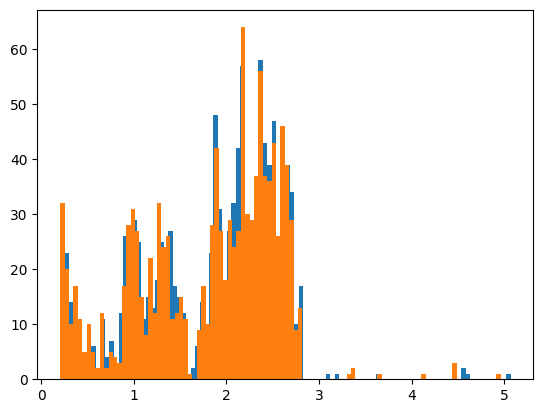

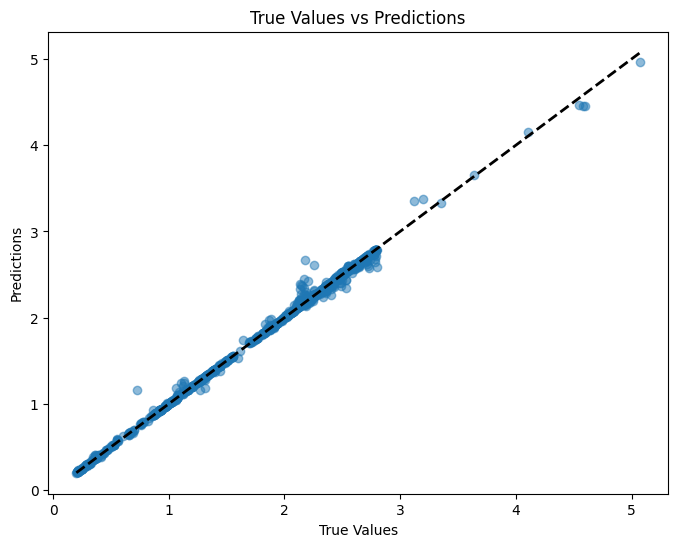

In [29]:
# %%
# Plot histogram of the test and of the predicted values
plt.hist(y_test, bins=100, label='test')    
plt.hist(y_pred, bins=100, label='predicted')

# %%
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) 
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

In [30]:
# %%
# Set the initial conditions
initial_conditions = [1.0, 0.0, 0.0, 0.1]
t_max = 30  # value that we used for training
num_points = 100  # same we used in training
subsample_size = 30  # same we used in training
t = np.linspace(0, t_max, num_points)
# Generate the time series data
#t, x, y, v_x, v_y = simulate_modified_newtonian(initial_conditions, np.linspace(0, t_max, num_points), 1, 1)

x = simulate_modified_newtonian(initial_conditions, t, 1, 1)[0]
y = simulate_modified_newtonian(initial_conditions, t, 1, 1)[1]
v_x = simulate_modified_newtonian(initial_conditions, t, 1, 1)[2]
v_y = simulate_modified_newtonian(initial_conditions, t, 1, 1)[3]

# Subsample the data
t_sub, x_sub, y_sub, v_x_sub, v_y_sub = subsample_time_series(t, x, y, v_x, v_y, subsample_size)

# Extract features
features = extract_features(x_sub, y_sub, v_x_sub, v_y_sub)

# Select only the features used in training
selected_features = ['x_mean', 'x_var', 'x_skew', 'x_kurt', 'v_x_mean', 'v_x_var', 'v_x_skew', 'v_x_kurt']
features_for_prediction = {feature: features[feature] for feature in selected_features}

# Create a DataFrame for prediction
features_df = pd.DataFrame([features_for_prediction])

# Predict with the model
predicted_peak_frequency = rf_regressor.predict(features_df)

print(f"Predicted Peak Frequency: {predicted_peak_frequency[0]}")

Predicted Peak Frequency: 1.8387544389675066
